# Tracking candidate paths from multi-path exploration

In [253]:
import sys
sys.path.append('../')
from panav.viz import draw_env
from panav.multi_path import explore_multi_path
from panav.env import NavigationEnv,box_2d_center,Box2DRegion

import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Empty Environment

In [363]:

# 2D navigation environment

start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

top, bottom = 8,-8
start_x_offset = 6
goal_x_offset = 8
N = 4

start_locs = np.vstack([
np.vstack([np.ones(N)*start_x_offset,np.linspace(top,bottom, N)]).T,
np.vstack([np.ones(N)*(-start_x_offset),np.linspace(top,bottom, N)]).T])

goal_locs = np.vstack([
np.vstack([np.ones(N)*(-goal_x_offset),np.linspace(bottom,top, N)]).T,
np.vstack([np.ones(N)*goal_x_offset,np.linspace(bottom,top, N)]).T])


starts = [box_2d_center(s,start_box_side) for s in start_locs]
goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

start = np.array(list(starts[-1].centroid().coords)[0])
goal = np.array(list(goals[-1].centroid().coords)[0])

limits = [(-10.0,10.0),(-10.0,10.0)]

# Construct the hybrid graph representation of the environment
bloating_r = 0.5 
env = NavigationEnv(limits,[],starts,goals)

## Two circles environment

In [364]:
from panav.env import approxCircle
obstacles = []
R = 3.5

obstacles += approxCircle(np.array([0,5.0]),R)
obstacles += approxCircle(np.array([0,-5]),R)

env = NavigationEnv(limits,obstacles,starts,goals)

# Explore candidate paths

In [365]:
candidate_paths = explore_multi_path(env,start,goal)

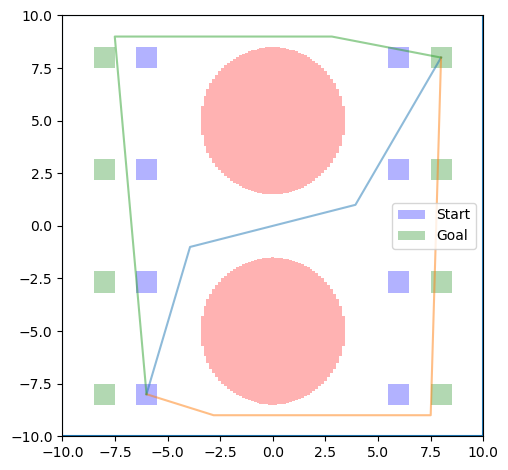

In [366]:
ax = plt.gca()
draw_env(env,candidate_paths,ax)
plt.tight_layout()
plt.savefig('./figures/TrackingReferencePath_candidates.png')
plt.show()    


# Generate moving obstacles

In [367]:
from panav.SAMP import Tube_Planning
from panav.util import unique_tx
from time import time
agents = range(N*2-1)
plan = []
times = []
success = True
fail_time = None
for agent in agents:
    print(agent)
    t0 = time()

    
    start = env.starts[agent]
    goal = env.goals[agent]

    agent_success = False
    
    
    for K in range(1,8):
        print("K",K)
        results = Tube_Planning(env,start, goal, 1.0 , bloating_r, 
                                obs_trajectories=plan, 
                                d=2, K=K,
                                ignore_finished_agents = False)

        if results is not None:
            t,xs = results
            times.append(time()-t0)
            print(times[-1])
            t,xs = unique_tx(t,xs)
            plan.append((t,xs))
            agent_success = True
            break
        

    if not agent_success:
        print("Solution failed.")
        success = False
        times.append(time()-t0)
        break


0
K 1
K 2
K 3
0.583298921585083
1
K 1
K 2
K 3
0.7721948623657227
2
K 1
K 2
K 3
K 4
1.1993227005004883
3
K 1
K 2
K 3
K 4
1.0967857837677002
4
K 1
K 2
K 3
K 4
1.878283977508545
5
K 1
K 2
K 3
K 4
K 5
7.235523223876953
6
K 1
K 2
K 3
K 4
K 5
8.131541013717651


3
4
5
6
7
8
9
10
11
12


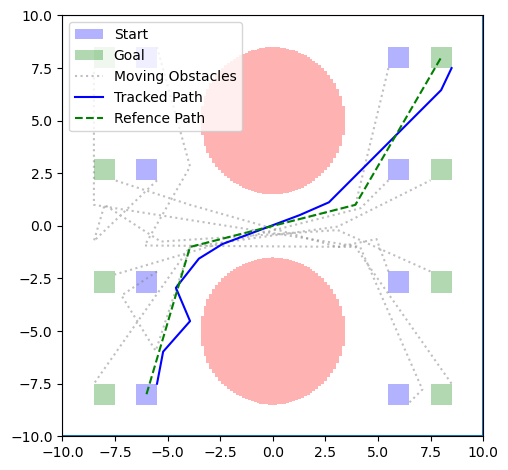

3


/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/cvxpy/problems/problem.py:1391: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)


4
5
6
7


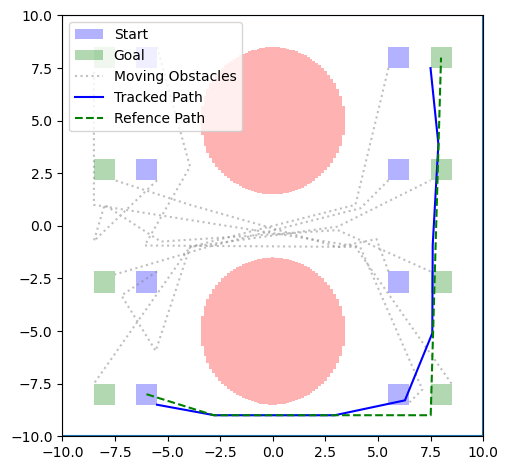

3


/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/cvxpy/problems/problem.py:1391: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)


4
5
6
7
8
9
10
11
12


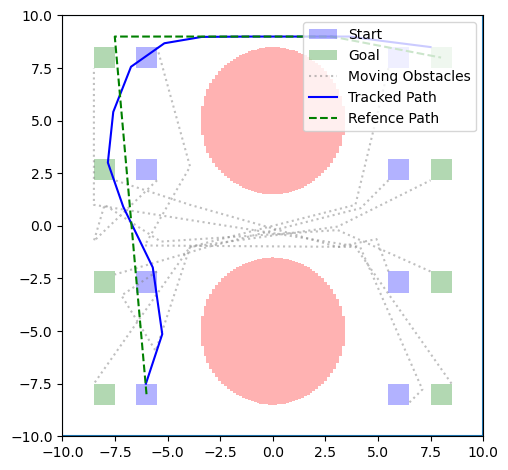

In [383]:
from panav.SAMP import track_ref_path,track_ref_path_v2

obstacles = [x for t,x in plan]

for cand_id in [0,1,2]:
    ref_path = candidate_paths[cand_id]

    vmax = 1.0
    bloating_r = 0.5
    obstacle_trajectories = plan
    # obstacle_trajectories = []

    d = 2
    # t, tracked_path = track_ref_path(env,starts[-1],goals[-1],ref_path,1.0,0.5, obstacle_trajectories,2,alpha = 1e5)
    t, tracked_path = track_ref_path_v2(env,starts[-1],goals[-1],ref_path,1.0,0.5, obstacle_trajectories,2,max_dev=1.0)
    ax = plt.gca()
    draw_env(env,[],ax)

    for a in range(len(obstacles)):    
        ax.plot(obstacles[a][0,:],obstacles[a][1,:],color = 'gray',ls = "dotted",alpha = 0.5,
                label = "Moving Obstacles" if a==0 else None)


    ax.plot(tracked_path[0,:],tracked_path[1,:],color = 'blue',label = 'Tracked Path')
    ax.plot(ref_path[0,:],ref_path[1,:],color = 'green',label = 'Refence Path',ls='dashed')
    # ax.plot(tracked_path[0,:],tracked_path[1,:],color = 'blue',label = 'Tracked Path')
    plt.legend()
    plt.tight_layout()
    plt.savefig('./figures/TrackingReferencePath{}.png'.format(cand_id))
    plt.show()    

    from panav.viz import interpolate_positions

    from IPython.display import HTML, display


    from matplotlib.animation import FuncAnimation
    from matplotlib.patches import Circle
    def animation(env,obstacle_paths, agent_path, reference_path,bloating_r,dt,fig=None,ax=None,obstacle_discs = None,hide_path_lines = True):
        '''
            Animate multi-agent trajectories in the given env.
            
            paths: paths[i](shape = (dim,n_steps)) is the path for agent i.
            
            bloat_r: the bloating radius of all agents.
            
            dt: time interval between two consecutive frames, measured in seconds.
        '''
        if fig is None:
            fig = plt.figure()
        if ax is None:
            ax = plt.gca()

        

        obstacles = range(len(obstacle_paths))

        # for a in agents:
        #     ax.plot(paths[a][:,0],paths[a][:,1],alpha = 0.5)

        if obstacle_discs is None:
            obstacle_discs = []
            for a in obstacles:
                disc = Circle(obstacle_paths[a][:,0],bloating_r,color = 'gray',label = 'Moving Obstacle' if a == 0 else None)
                obstacle_discs.append(disc)
        agent_disc = Circle(agent_path[:,0],bloating_r,color = 'blue',label = 'Agent')

        discs = obstacle_discs+[agent_disc]
        for disc in discs:
            ax.add_artist(disc)

        paths = obstacle_paths + [agent_path]
        
            
        draw_env(env,[], ax)

        ax.plot(reference_path[0,:],reference_path[1,:],color = 'green',label = 'Refence Path',ls='dashed')

        def init_func():
            return discs

        def animate(t):
            for a in range(len(discs)):
                disc = discs[a]
                if t<paths[a].shape[-1]:
                    disc.center = paths[a][0,t], paths[a][1,t]
                
            return discs

        handles, labels = ax.get_legend_handles_labels()
        if len(labels)>0:
            ax.legend()

        anim = FuncAnimation(fig,animate,frames = max([p.shape[-1] for p in paths]),blit=True,interval = dt*1000)
        return anim

    interp_dt = 0.1

    obstacle_traj = []
    for cp in plan:
        _,xs = interpolate_positions(*cp,interp_dt)
        obstacle_traj.append(xs)

    _, agent_path = interpolate_positions(t,tracked_path,interp_dt)
    anim = animation(env, obstacle_traj, agent_path, ref_path, bloating_r, dt = interp_dt / 4)
    # display(HTML(anim.to_jshtml()))
    anim.save("./figures/TrackingReferencePath{}.gif".format(cand_id))
    plt.close()   # Avoid plotting an extra figure.